# Лабораторна робота 8 (2 частина)

Романенко Ілля ФІТ 4-7

!!! ця робота була виконана локально, тому всі файли моделі були збережені також локально

In [1]:
# !pip install tensorflow
# !pip install --upgrade keras
# !pip install keras-tuner

In [2]:
import numpy as np
from tensorflow import keras

2024-10-09 17:55:18.091760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 17:55:18.108455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 17:55:18.113119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 17:55:18.124673: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 17:55:18.972339: W tensorflow/compiler/tf2

## Крок 1

завантажуємо датасет та готуємо данні

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [4]:
from keras.utils import to_categorical

x_train = x_train.reshape(-1, 28, 28)
x_test = x_test.reshape(-1, 28, 28)

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

## Крок 2

побудуємо функцію побудови моделі 

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization

def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(Dense
            (units=hp.Int(
                f'units_{i}',
                min_value=32,
                max_value=512,
            step=32), activation='relu'))
        
        model.add(BatchNormalization())

        model.add(Dropout(
            hp.Float(
                f'dropout_{i}',
                min_value=0.0,
                max_value=0.5,
                step=0.1)))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

## Крок 3

налаштовуємо тюнер та параметри раньої зупинки

In [6]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='models_tuned_2',
    project_name='fashion_mnist_tuning_2'
)

/tmp/ipykernel_59813/3930968778.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
/home/user/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

tuner.search_space_summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3
)

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


## Крок 4

запускаємо пошук найкращої моделі

In [8]:
tuner.search(
    x_train, y_train, 
    validation_data=(x_test, y_test), 
    epochs=50, 
    batch_size=64, 
    callbacks=[early_stopping, reduce_lr]
)


Trial 15 Complete [00h 00m 48s]
val_accuracy: 0.8919000029563904

Best val_accuracy So Far: 0.8989999890327454
Total elapsed time: 00h 29m 33s


виведемо результати тренування

In [9]:
tuner.results_summary()

Results summary
Results in models_tuned_2/fashion_mnist_tuning_2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 12 summary
Hyperparameters:
num_layers: 3
units_0: 96
dropout_0: 0.0
units_1: 416
dropout_1: 0.30000000000000004
units_2: 320
dropout_2: 0.1
units_3: 192
dropout_3: 0.0
Score: 0.8989999890327454

Trial 13 summary
Hyperparameters:
num_layers: 4
units_0: 448
dropout_0: 0.4
units_1: 192
dropout_1: 0.1
units_2: 480
dropout_2: 0.1
units_3: 160
dropout_3: 0.0
Score: 0.8971999883651733

Trial 03 summary
Hyperparameters:
num_layers: 4
units_0: 384
dropout_0: 0.1
units_1: 352
dropout_1: 0.1
units_2: 192
dropout_2: 0.0
units_3: 224
dropout_3: 0.0
Score: 0.896399974822998

Trial 07 summary
Hyperparameters:
num_layers: 4
units_0: 320
dropout_0: 0.0
units_1: 512
dropout_1: 0.0
units_2: 64
dropout_2: 0.30000000000000004
units_3: 96
dropout_3: 0.1
Score: 0.8959000110626221

Trial 04 summary
Hyperparameters:
num_layers: 3
units_0: 192
dropout_0: 0.1
units_1: 16

## Крок 5

натренуємо найкращу модель, що отримали за допомогою тюнування

In [11]:
best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9268 - loss: 0.1918 - val_accuracy: 0.8739 - val_loss: 0.4074 - learning_rate: 0.0010
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9270 - loss: 0.1896 - val_accuracy: 0.8855 - val_loss: 0.3570 - learning_rate: 0.0010
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9304 - loss: 0.1846 - val_accuracy: 0.8892 - val_loss: 0.3746 - learning_rate: 0.0010
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9291 - loss: 0.1879 - val_accuracy: 0.8851 - val_loss: 0.3645 - learning_rate: 0.0010
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9295 - loss: 0.1834 - val_accuracy: 0.8930 - val_loss: 0.3647 - learning_rate: 0.0010
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9382 - loss: 0.1627 - val_accuracy: 0.8983 - val_loss: 0.3533 - learning_rate: 5.0000e-04
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9436 - loss: 0.145

## Крок 6

оцінимо отриману найкращу модель

### побудуємо графіки функції втрат та точності

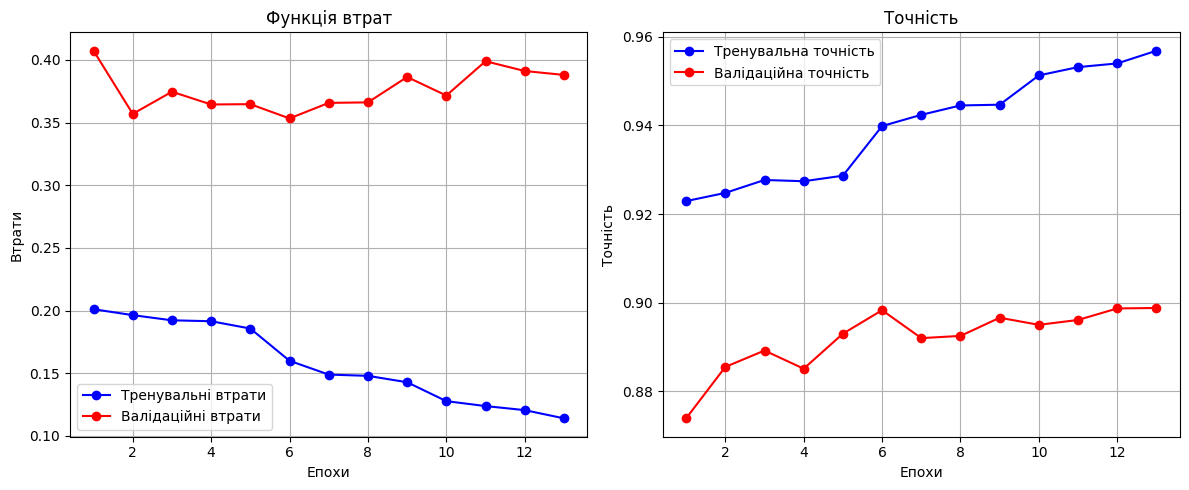

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Тренувальні втрати')
plt.plot(epochs, val_loss, 'ro-', label='Валідаційні втрати')
plt.title('Функція втрат')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Тренувальна точність')
plt.plot(epochs, val_accuracy, 'ro-', label='Валідаційна точність')
plt.title('Точність')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### виведемо класифікаційний звіт

In [16]:
from sklearn.metrics import classification_report

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

y_pred = np.argmax(best_model.predict(x_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
print(classification_report(y_true, y_pred, target_names=class_names))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.86      0.84      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.81      0.85      0.83      1000
       Dress       0.89      0.90      0.89      1000
        Coat       0.84      0.82      0.83      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.76      0.70      0.73      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [18]:
import pandas as pd

results = pd.DataFrame({'True Label': y_true, 'Predicted Label': y_pred})
print(results.head(10))

   True Label  Predicted Label
0           9                9
1           2                2
2           1                1
3           1                1
4           6                6
5           1                1
6           4                4
7           6                6
8           5                5
9           7                7


збережемо модель

In [17]:
best_model.save('models/mnist_tuned_model.keras')

## Крок 7

порівняємо дві моделі

завантажуємо з локальної машини

In [20]:
from tensorflow.keras.models import load_model

model_original = load_model('models/mnist_model_59_06_16_09_10_2024.keras')
model_tuned = load_model('models/mnist_tuned_model.keras')

In [26]:
score_original = model_original.evaluate(x_test, y_test, verbose=0)
score_tuned = model_tuned.evaluate(x_test, y_test, verbose=0)

print(f"Оригінальна модель - Loss: {score_original[0]:.4f}, Accuracy: {score_original[1]:.4f}")
print(f"Тюнована модель    - Loss: {score_tuned[0]:.4f}, Accuracy: {score_tuned[1]:.4f}")

Оригінальна модель - Loss: 0.4233, Accuracy: 0.8794
Тюнована модель    - Loss: 0.3533, Accuracy: 0.8983


In [25]:
y_pred_original = np.argmax(model_original.predict(x_test), axis=-1)
y_pred_tuned = np.argmax(model_tuned.predict(x_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

print("Оригінальна модель:")
print(classification_report(y_true, y_pred_original))

print("Тюнована модель:")
print(classification_report(y_true, y_pred_tuned))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Оригінальна модель:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1000
           1       0.99      0.96      0.98      1000
           2       0.78      0.82      0.80      1000
           3       0.89      0.87      0.88      1000
           4       0.80      0.80      0.80      1000
           5       0.97      0.93      0.95      1000
           6       0.72      0.67      0.69      1000
           7       0.93      0.96      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Тюнована модель:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1 

## Висновки

В ході побудови різних моделей, як вручну, так і за допомогою тюнера, отримали наступний результат - так, тюнування моделей загалом показує кращий результат, і може показати набагато кращий результат при більших та складніших моделях.

Тюнування в даному випадку дало умовний приріст в 2%, з 88% точності, до 90%, що дає загалом кращий результат, хоч і потребувало більших затрат по часу. Загалом оптимізація гіперпараметрів дозволила зробити модель більш точною.